In [32]:
# This routine can calculate El Nino Southern Oscillation index and pattern
# It uses Nino boxes as described here:
# https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from tqdm import tqdm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.fft import fft, fftfreq
import matplotlib.tri as mtri
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.cm import ScalarMappable
from scipy import signal
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline
import matplotlib.pylab as pylab

In [2]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
abg = [0, 0, 0]
variable = 'sst'
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom/']
obs_path = '/p/project/chhb19/streffing1/obs/hadisst2/box'
years = range(1850, 2015)

box='Nino34'

figsize=(9,5.56)
dpi = 300
ofile = 'ENSO'

In [3]:
# load mesh and data
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

data_raw = pf.get_data(input_paths[0], 'sst', years, mesh, how=None, compute=False, silent=True)

model_lon = mesh.x2
model_lon = np.where(model_lon < 0, model_lon+360, model_lon)
model_lat = mesh.y2

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
('time', 'nod2')
False
False
True


In [4]:
np.shape(model_lon)

(126858,)

In [5]:
from cdo import *   # python version
cdo = Cdo()
obs_raw = cdo.copy(input=str(obs_path),returnArray='sst')
del cdo
from scipy import signal
obs_raw = obs_raw[0:1812]

In [6]:
# Detrend linearly to remove forcing or spinup induced trends
# TODO: probably better to detrend with something like a 50 year running mean
data_raw = signal.detrend(data_raw)
#obs_raw = signal.detrend(obs_raw)

# Reshape to add monthly time axis
data_raw_reshape = data_raw.reshape(data_raw.shape[0]//12,data_raw.shape[1], 12)
obs_raw_reshape = obs_raw.reshape(obs_raw.shape[0]//12,obs_raw.shape[1],obs_raw.shape[2], 12)

# Calculate seasonal cycle
data_season_cycle = np.mean(data_raw_reshape,axis=0)
obs_season_cycle = np.mean(obs_raw_reshape,axis=0)

# Repeat seasonal cycle
data_season_cycle_repeat = np.repeat(data_season_cycle[np.newaxis,...],np.shape(data_raw_reshape)[0],axis=0)
obs_season_cycle_repeat = np.repeat(obs_season_cycle[np.newaxis,...],np.shape(obs_raw_reshape)[0],axis=0)

# Reshape into original format
data_season_cycle_repeat_reshape = data_season_cycle_repeat.reshape(np.shape(data_raw))
obs_season_cycle_repeat_reshape = obs_season_cycle_repeat.reshape(np.shape(obs_raw))

# Remove seasonal cycle from data
data = data_raw - data_season_cycle_repeat_reshape
obs = obs_raw - obs_season_cycle_repeat_reshape

![caption](https://climatedataguide.ucar.edu/sites/default/files/users/dschneid/key_figures_428.png)

In [7]:
# select Nino index region

if box == 'Nino12':
    lon_min=270 #(-90+360) 
    lon_max=280 #(-80+360) 
    lat_min=-10
    lat_max= 0
elif box == 'Nino3':
    lon_min=210 #(-150+360)
    lon_max=270 #(-90+360)
    lat_min=-5
    lat_max= 5
elif box == 'Nino34':
    lon_min=190 #(-170+360)
    lon_max=240 #(-120+360)
    lat_min=-5
    lat_max= 5
elif box == 'Nino4':
    lon_min=160 
    lon_max=210 #(-150+360)
    lat_min=-5
    lat_max= 5

    
    
lon = np.linspace(lon_min, lon_max, lon_max-lon_min)
lat = np.linspace(lat_min, lat_max, lat_max-lat_min)
lon2, lat2 = np.meshgrid(lon, lat)

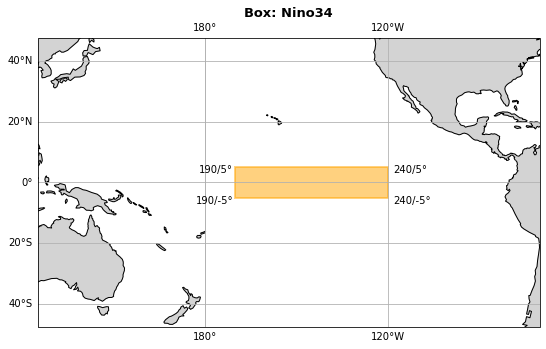

In [8]:
# visulatize nino boxes
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

figsize=figsize
projection = ccrs.PlateCarree()

# Plot the leading EOF expressed as correlation in the Pacific domain.
plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title('Box: '+box, fontsize=13,fontweight="bold")
plt.text(lon_min-193,lat_min-2,str(lon_min)+'/'+str(lat_min)+'°')
plt.text(lon_min-192,lat_max-2,str(lon_min)+'/'+str(lat_max)+'°')
plt.text(lon_max-178,lat_max-2,str(lon_max)+'/'+str(lat_max)+'°')
plt.text(lon_max-178,lat_min-2,str(lon_max)+'/'+str(lat_min)+'°')


ax.set_extent([125, -70, 8, -8])
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=lon_max-lon_min, height=lat_max-lat_min,
                                    facecolor='Orange',
                                    alpha=0.5,
                                    edgecolor='Orange',
                                    lw='2',
                                    transform=ccrs.PlateCarree())
                 )
ax.tick_params(labelsize=13)

if ofile is not None:
    ofile_long = f"{ofile}_"+box+"_enso_box_map.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

In [9]:
# interpolate data onto regular grid
sst = []
points = np.vstack((model_lon, model_lat)).T
for t in tqdm(range(0, np.shape(data_raw)[0])):
    nn_interpolation = NearestNDInterpolator(points, data[t,:])
    sst.append(nn_interpolation((lon2, lat2)))
sst=np.asarray(sst)
sst_area_mean = np.mean(np.mean(sst,axis=2),axis=1)
sst_nino = sst_area_mean.reshape(len(sst_area_mean)//12, 12)
sst_nino_ano = sst_nino - np.mean(sst_nino)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1980/1980 [01:23<00:00, 23.77it/s]


In [10]:
np.shape(lat2)

(10, 50)

In [11]:
obs_nino = obs.reshape(len(obs)//12, 12)
obs_nino_ano = obs_nino - np.mean(obs_nino)

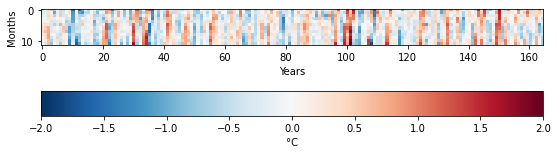

In [12]:
plt.figure(figsize = figsize)
plt.imshow(np.transpose(sst_nino),cmap=plt.cm.RdBu_r,vmin=-2, vmax=2) 
cbar = plt.colorbar(orientation='horizontal')
plt.ylabel("Months")
plt.xlabel("Years")

cbar.set_label('°C', rotation=0)

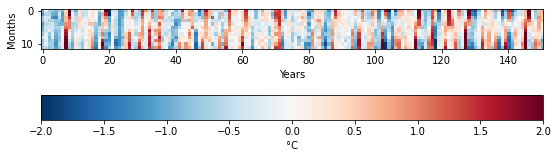

In [13]:
plt.figure(figsize = figsize)
plt.imshow(np.transpose(obs_nino),cmap=plt.cm.RdBu_r, vmin=-2, vmax=2) 
cbar = plt.colorbar(orientation='horizontal')
plt.ylabel("Months")
plt.xlabel("Years")

cbar.set_label('°C', rotation=0)

In [14]:
def smooth3(x,beta):
    """ kaiser window smoothing """
    window_len=3
    beta=2
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[1:len(y)-1]

In [15]:
# Seasonal smoothing
sst_nino_ano_smooth=smooth3(sst_nino_ano.flatten(),len(sst_nino_ano.flatten()))
obs_nino_ano_smooth=smooth3(obs_nino_ano.flatten(),len(obs_nino_ano.flatten()))

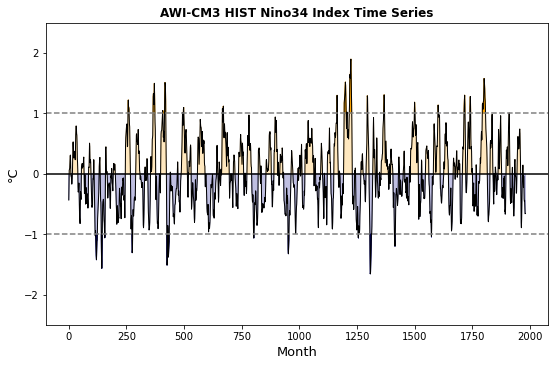

In [16]:
# Plot the leading PC time series.

plt.figure(figsize=figsize)
plt.plot(sst_nino_ano_smooth, color='black', linewidth=1) 
plt.axhline(0, color='k')
plt.title('AWI-CM3 HIST '+box+' Index Time Series',fontweight="bold")
plt.xlabel('Month',fontsize=13)
plt.ylabel('°C',fontsize=13)
ax.tick_params(labelsize=13)

plt.ylim(-2.5, 2.5)
plt.axhline(y=1, color='grey', linestyle='--')
plt.axhline(y=-1, color='grey', linestyle='--')

months = np.arange(len(sst_nino_ano.flatten()))

plt.fill_between(months, sst_nino_ano_smooth, 0, where = (sst_nino_ano_smooth > 0), color='Orange',alpha=0.25)
plt.fill_between(months, sst_nino_ano_smooth, -0, where = (sst_nino_ano_smooth < -0), color='darkblue',alpha=0.25)

plt.fill_between(months, sst_nino_ano_smooth, 1, where = (sst_nino_ano_smooth > 1), color='Orange')
plt.fill_between(months, sst_nino_ano_smooth, -1, where = (sst_nino_ano_smooth < -1), color='darkblue')


if ofile is not None:
    ofile_long = f"{ofile}_"+box+"_enso_box_index.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

In [17]:
np.shape(sst)

(1980, 10, 50)

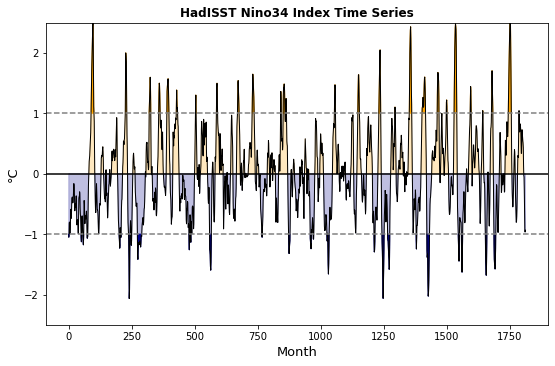

In [18]:
# Plot the leading PC time series.

plt.figure(figsize=figsize)
plt.plot(obs_nino_ano_smooth, color='black', linewidth=1) 
plt.axhline(0, color='k')
plt.title('HadISST '+box+' Index Time Series',fontweight="bold")
plt.xlabel('Month',fontsize=13)
plt.ylabel('°C',fontsize=13)
ax.tick_params(labelsize=13)

plt.ylim(-2.5, 2.5)
plt.axhline(y=1, color='grey', linestyle='--')
plt.axhline(y=-1, color='grey', linestyle='--')

months = np.arange(len(obs_nino_ano.flatten()))

plt.fill_between(months, obs_nino_ano_smooth, 0, where = (obs_nino_ano_smooth > 0), color='Orange',alpha=0.25)
plt.fill_between(months, obs_nino_ano_smooth, -0, where = (obs_nino_ano_smooth < -0), color='darkblue',alpha=0.25)
plt.fill_between(months, obs_nino_ano_smooth, 1, where = (obs_nino_ano_smooth > 1), color='Orange')
plt.fill_between(months, obs_nino_ano_smooth, -1, where = (obs_nino_ano_smooth < -1), color='darkblue')


if ofile is not None:
    ofile_long = f"HadISST_"+box+"_enso_box_index.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

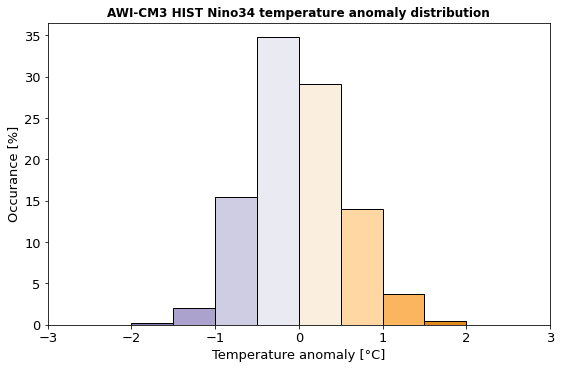

In [19]:
# Obtain data
Ntotal = len(sst_nino_ano_smooth)
data = sst_nino_ano_smooth

# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('PuOr_r')

# Get the histogramp
nbins = 13
minbin = -3
maxbin = 3
bins = np.linspace(minbin,maxbin,nbins)

Y,X = np.histogram(data, bins=bins)
Y = (Y*100)/np.sum(Y)
x_span = X.max()-X.min()
corr=(x_span/nbins)/2
C = [cm(((x-X.min()+corr)/x_span)) for x in X]

fig, ax = plt.subplots(figsize=figsize)

plt.bar(X[:-1],Y,color=C,width=X[1]-X[0],edgecolor='black',align='edge')
plt.xlim((minbin, maxbin))
plt.title('AWI-CM3 HIST '+box+' temperature anomaly distribution',fontweight="bold")
plt.ylabel("Occurance [%]",fontsize=13)
plt.xlabel("Temperature anomaly [°C]",fontsize=13)
ax.tick_params(labelsize=13)


if ofile is not None:
    ofile_long = f"{ofile}_"+box+"_enso_temperature_distribution.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

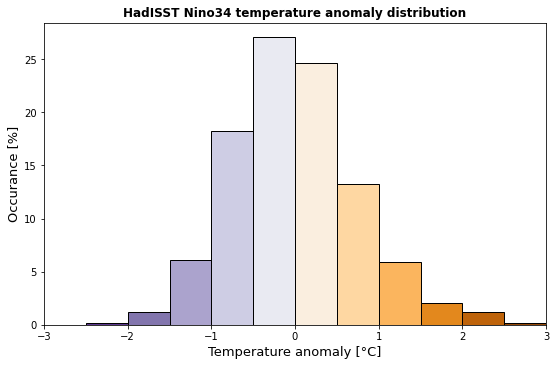

In [20]:
# Obtain data
Ntotal = len(obs_nino_ano_smooth)
data = obs_nino_ano_smooth

# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('PuOr_r')

# Get the histogramp
nbins = 13
minbin = -3
maxbin = 3
bins = np.linspace(minbin,maxbin,nbins)

Y,X = np.histogram(data, bins=bins)
Y = (Y*100)/np.sum(Y)
x_span = X.max()-X.min()
corr=(x_span/nbins)/2
C = [cm(((x-X.min()+corr)/x_span)) for x in X]

fig, ax = plt.subplots(figsize=figsize)

plt.bar(X[:-1],Y,color=C,width=X[1]-X[0],edgecolor='black',align='edge')
plt.xlim((minbin, maxbin))
plt.title('HadISST '+box+' temperature anomaly distribution',fontweight="bold")
plt.ylabel("Occurance [%]",fontsize=13)
plt.xlabel("Temperature anomaly [°C]",fontsize=13)

if ofile is not None:
    ofile_long = f"HadISST_"+box+"_enso_temperature_distribution.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

In [104]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=101
    beta=100
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[50:len(y)-50]

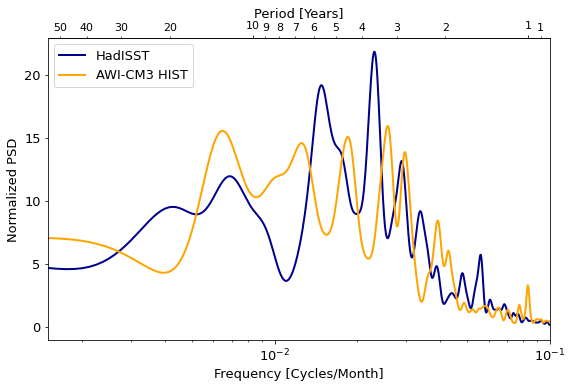

In [103]:
f, Pxx_den = signal.periodogram(sst_nino_ano.flatten(),nfft=8000)
f_obs, Pxx_den_obs = signal.periodogram(obs_nino_ano.flatten(),nfft=8000)
#f_obsn, Pxx_den_obsn = signal.periodogram(obs_nino_ano.flatten(),nfft=250)

fig, ax = plt.subplots(figsize=figsize)

#ax.plot(f_obsn,Pxx_den_obsn/np.mean(Pxx_den_obsn),linewidth=1,color='orange',label='HadISST')

ax.semilogx(f_obs,smooth(Pxx_den_obs/np.mean(Pxx_den_obs),len(Pxx_den)),linewidth=2,color='darkblue',label='HadISST')
ax.semilogx(f,smooth(Pxx_den/np.mean(Pxx_den),len(Pxx_den)),linewidth=2,color='orange',label='AWI-CM3 HIST')


ax.set_xlim([0.0015, 0.1])
#ax.set_ylim([0.01, 25])
plt.xlabel('Frequency [Cycles/Month]',fontsize=13)
plt.ylabel('Normalized PSD',fontsize=13)
plt.legend(loc='upper left',fontsize=13)
#ax.set_xscale('log')
ax.tick_params(labelsize=13)

def twelve_over(x):
    """Vectorized 12/x, treating x==0 manually"""
    x = np.array(x*12).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

# the function "12/x" is its own inverse
inverse = twelve_over

#secax.set_xticks([50,12,8,6,5,4,3,2,1])
secax = ax.secondary_xaxis('top', functions=(twelve_over, inverse))
secax.set_xlabel('Period [Years]',fontsize=13)
secax.set_xlabel('Period [Years]',fontsize=13)
secax.xaxis.set_major_formatter(FormatStrFormatter("%1.f"))
secax.xaxis.set_minor_formatter(FormatStrFormatter("%1.f"))
secax.tick_params(axis='x', which='major', labelsize=11)
secax.tick_params(axis='x', which='minor', labelsize=11)

if ofile is not None:
    ofile_long = f"{ofile}_enso_"+box+"_box_norm_psd.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')


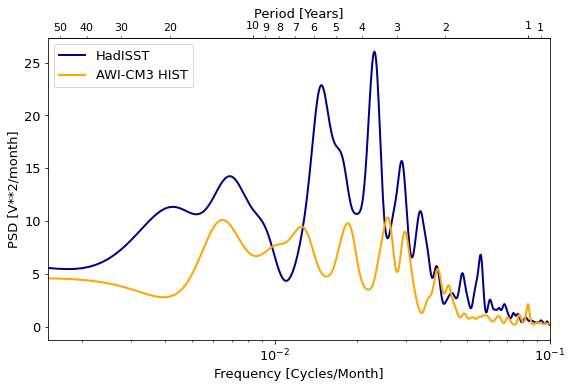

In [83]:
f, Pxx_den = signal.periodogram(sst_nino_ano.flatten(),nfft=8000)
f_obs, Pxx_den_obs = signal.periodogram(obs_nino_ano.flatten(),nfft=8000)
#f_obsn, Pxx_den_obsn = signal.periodogram(obs_nino_ano.flatten(),nfft=250)

fig, ax = plt.subplots(figsize=figsize)

#ax.plot(f_obsn,Pxx_den_obsn/np.mean(Pxx_den_obsn),linewidth=1,color='orange',label='HadISST')

ax.semilogx(f_obs,smooth(Pxx_den_obs,len(Pxx_den)),linewidth=2,color='darkblue',label='HadISST')
ax.semilogx(f,smooth(Pxx_den,len(Pxx_den)),linewidth=2,color='orange',label='AWI-CM3 HIST')


ax.set_xlim([0.0015, 0.1])
#ax.set_ylim([0.01, 25])
plt.xlabel('Frequency [Cycles/Month]',fontsize=13)
plt.ylabel('PSD [V**2/month]',fontsize=13)
plt.legend(loc='upper left',fontsize=13)
#ax.set_xscale('log')
ax.tick_params(labelsize=13)

def twelve_over(x):
    """Vectorized 12/x, treating x==0 manually"""
    x = np.array(x*12).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

# the function "12/x" is its own inverse
inverse = twelve_over

#secax.set_xticks([50,12,8,6,5,4,3,2,1])
secax = ax.secondary_xaxis('top', functions=(twelve_over, inverse))
secax.set_xlabel('Period [Years]',fontsize=13)
secax.set_xlabel('Period [Years]',fontsize=13)
secax.xaxis.set_major_formatter(FormatStrFormatter("%1.f"))
secax.xaxis.set_minor_formatter(FormatStrFormatter("%1.f"))
secax.tick_params(axis='x', which='major', labelsize=11)
secax.tick_params(axis='x', which='minor', labelsize=11)

if ofile is not None:
    ofile_long = f"{ofile}_enso_"+box+"_box_abs_psd.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')


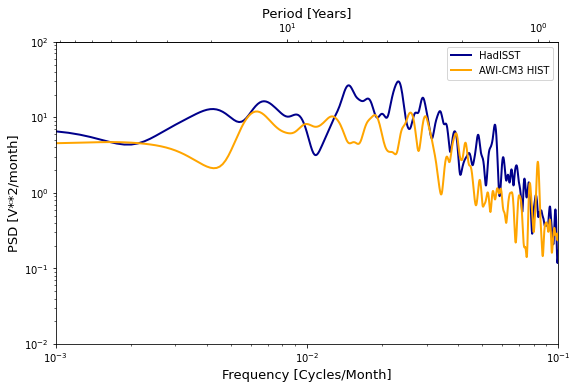

In [105]:
f, Pxx_den = signal.periodogram(sst_nino_ano.flatten(),nfft=8000)
f_obs, Pxx_den_obs = signal.periodogram(obs_nino_ano.flatten(),nfft=8000)

fig, ax = plt.subplots(figsize=figsize)

#ax.loglog(f_obs,Pxx_den_obs/np.mean(Pxx_den_obs),linewidth=1,color='darkblue',label='HadISST')
#ax.loglog(f,Pxx_den/np.mean(Pxx_den),linewidth=1,color='orange',label='AWI-CM3 HIST')

ax.loglog(f_obs,smooth(Pxx_den_obs,len(Pxx_den)),linewidth=2,color='darkblue',label='HadISST')
ax.loglog(f,smooth(Pxx_den,len(Pxx_den)),linewidth=2,color='orange',label='AWI-CM3 HIST')


ax.set_xlim([0.001, 0.1])
ax.set_ylim([0.01, 100])
plt.xlabel('Frequency [Cycles/Month]',fontsize=13)
plt.ylabel('PSD [V**2/month]',fontsize=13)
plt.legend(loc='upper right')

def twelve_over(x):
    """Vectorized 12/x, treating x==0 manually"""
    x = np.array(x*12).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

# the function "12/x" is its own inverse
inverse = twelve_over

secax = ax.secondary_xaxis('top', functions=(twelve_over, inverse))
secax.set_xlabel('Period [Years]',fontsize=13)
#secax.set_xticks([50,12,8,6,5,4,3,2,1])

if ofile is not None:
    ofile_long = f"{ofile}_enso_"+box+"_box_abs_psd_loglog.png"
    plt.savefig(f"{ofile_long}", dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')
